In [2]:
library(ANCOMBC)
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")

Loading required package: phyloseq


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2020 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: ‘microbiome’


The following object is masked from ‘package:ggplot2’:

    alpha


The following object is masked from ‘package:base’:

    transform


── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ readr   2.1.2     ✔ stringr 1.4.0
✔ purrr   0.3.4     ✔ forcats 0.5.1
✔ dplyr   1.0.9     

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ microbiome::alpha() masks ggplot2::alpha()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [3]:
# Read in the 16S qza files and clean them up for phyloseq
ASVs <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/table-BacArc_resistada.qza")
ASVs <- ASVs$data # Extract the count data from list
taxa_16S <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/taxonomy_resistada.qza")
taxa_16S <- taxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>% 
# Convert taxonomy info to data frame with correct taxonomy labels
#taxa <- taxa_16S[-1,]
select(-Confidence) %>% arrange(Feature.ID) %>% mutate(ASV = 1:n()) %>% 
mutate(newcol = "ASV") %>%
unite("ASVs", newcol:ASV) %>%
filter(Phylum !=" p__Chlorophyta") %>%
filter(Phylum !="NA")
#asv_tab$asv_id <- rownames(asv_tab) # add a new column for ids
tree_file <-read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/rooted-BacArc_resistada.qza")$data

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 5374 rows [3, 6, 9, 11, 12, 14, 15, 16, 17, 18, 22, 23, 27, 31, 36, 38, 42, 45, 49, 51, ...].”


In [4]:
meta = read.csv("/Users/stephanie.rosales/Documents/omics_projects/Resitada/metadata_RESISTADA.csv", 
                header = T, row.names = 1,
na.strings = c("", "NA"))



In [12]:
ps= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(as.data.frame(taxa_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(meta), tree_file)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [6]:
dups = c("N169_256_R2", "N157_265_R2", "N165_296_R2", "N161_A067_R2", "N185_A088_R2",
                                 "N164_A089_R2","N119_A107","N267_A110","N7_A114", "N156_A115","N158_A116",
                                 "N101_A118","N160_A119","N277_A125")

ps = subset_samples(ps, !ID %in% dups & Genotype!=c("U41"))
                                                    #,"U44")) 
ps


ps=subset_taxa(ps, Phylum!="NA")
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 257 samples ]
sample_data() Sample Data:       [ 257 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 257 samples ]
sample_data() Sample Data:       [ 257 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [7]:
ps_Clipped =subset_samples(ps, Type=="Clipped")
ps_Clipped

ps_paired = subset_samples(ps_Clipped, Pairs=="paired")
ps_paired

#ps_Am_Pl_c =subset_samples(ps_paired, Combo=="Ambient_Placebo")
#ps_Am_Pl_c

#ps_Am_Pa_c =subset_samples(ps_paired, Combo=="Ambient_Pathogen")
#ps_Am_Pa_c

#ps_NH_Pl_c =subset_samples(ps_paired, Combo=="NH4_Placebo")
#ps_NH_Pl_c

#ps_NH_Pa_c =subset_samples(ps_paired, Combo=="NH4_Pathogen")
#ps_NH_Pa_c

#ps_placebo =subset_samples(ps_paired, Diseased=="Placebo")
#ps_placebo

#ps_placebo_un =subset_samples(ps_Clipped, Diseased=="Placebo")
#ps_placebo_un

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [8]:
                         

ps_fill_clip = filter_taxa(ps_Clipped, function(x) sum(x > 5) > (0.1*length(x)), TRUE)
ps_fill_clip
                           
                                                                                     
ps_fill_pair = filter_taxa(ps_paired, function(x) sum(x > 5) > (0.10*length(x)), TRUE)
ps_fill_pair  
                           
                                       
                             


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 94 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 94 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 94 tips and 75 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 117 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 117 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 117 tips and 96 internal nodes ]

In [8]:
sample_data(ps_fill_pair) %>%
  group_by(Combo, Health) %>%
  summarize(Paired = n())

`summarise()` has grouped output by 'Combo'. You can override using the `.groups` argument.


Combo,Health,Paired
<chr>,<chr>,<int>
Ambient_Pathogen,AH,3
Ambient_Pathogen,DL,23
Ambient_Placebo,AH,36
NH4_Pathogen,AH,2
NH4_Pathogen,DL,30
NH4_Placebo,AH,36
NH4_Placebo,DL,5


In [9]:
sample_data(ps_fill_pair) %>%
  group_by(Combo, Outcome) %>%
  summarize(Paired = n())

`summarise()` has grouped output by 'Combo'. You can override using the `.groups` argument.


Combo,Outcome,Paired
<chr>,<chr>,<int>
Ambient_Pathogen,Unaffected,3
Ambient_Pathogen,Unhealthy,23
Ambient_Placebo,Healthy,36
NH4_Pathogen,Unaffected,2
NH4_Pathogen,Unhealthy,30
NH4_Placebo,Healthy,36
NH4_Placebo,Unhealthy,5


# DL vs AH

In [16]:
out = ancombc(phyloseq = ps_fill_pair , formula = "Health", 
              p_adj_method = "fdr", zero_cut = 0.90, lib_cut = 1000, 
              group = "Health", struc_zero = TRUE, neg_lb = TRUE, tol = 1e-5, 
              max_iter = 100, conserve = TRUE, alpha = 0.01, global = FALSE)

res = out$res
res_global = out$res_global



df_fig1 = data.frame(res$beta * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("taxon_id")

head(df_fig1)

dim(df_fig1)

df_fig2 = data.frame(res$se * res$diff_abn, check.names = FALSE) %>% 
  rownames_to_column("taxon_id")
colnames(df_fig2)[-1] = paste0(colnames(df_fig2)[-1], "SD")
head(df_fig2)


df_fig = df_fig1 %>% left_join(df_fig2, by = "taxon_id") %>%
  transmute(taxon_id, HealthDL, HealthDLSD)%>%
  mutate(group = ifelse(HealthDL > 0, "DL", "AH"))
df_fig$taxon_id = factor(df_fig$taxon_id, levels = df_fig$taxon_id)


sigs=res$diff_abn %>% as.data.frame() %>%
select(HealthDL)  %>%
filter(HealthDL=="TRUE") %>%
rownames_to_column("taxon_id") %>%
rename(Sig=HealthDL)
head(sigs)


df_fig =df_fig %>% inner_join(sigs)

dim(df_fig)

res_ancom= df_fig %>%
mutate(Feature.ID = taxon_id) %>%
#rownames_to_column("taxon")
left_join(as.data.frame(taxa_16S), "Feature.ID") %>%
#select(taxon_id, Class, Order, Family, Genus, Taxon) %>%
column_to_rownames("taxon_id")%>%
as.matrix

ps_DLPL=phyloseq(otu_table(ASVs, taxa_are_rows=TRUE), 
               sample_data(meta),
              tax_table(res_ancom))
ps_DLPL=subset_samples(ps_DLPL, !ID %in% dups & Genotype!="U41")
ps_DLPL



ps_ancom_APa = subset_samples(ps_DLPL,
                      Type=="Clipped")
ps_ancom_APa = subset_samples(ps_ancom_APa, Pairs=="paired")
ps_ancom_APa

psr_fill_melt = ps_ancom_APa  %>%  
  #tax_glom("Genus") %>% 
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()    


Warning message in data_prep(phyloseq, group, zero_cut, lib_cut, global = global):
“The multi-group comparison will be deactivated as the group variable has < 3 categories.”


,taxon_id,HealthDL
,<chr>,<dbl>
1,2549b8aa248e7607235d17caa2578426,0
2,a14b7162edeb7a30ddb2a46656539857,0
3,7dfdf546ed4b1ca29ad5fbc0fc732338,0
4,544e3f697c0460869c81cc5c7e774c6a,0
5,94580582244d0d8eedb558e2a90c33fa,0
6,ef6c1ba3806541ebf351ab0fcb95fb75,0


[1] 117   2

,taxon_id,HealthDLSD
,<chr>,<dbl>
1,2549b8aa248e7607235d17caa2578426,0
2,a14b7162edeb7a30ddb2a46656539857,0
3,7dfdf546ed4b1ca29ad5fbc0fc732338,0
4,544e3f697c0460869c81cc5c7e774c6a,0
5,94580582244d0d8eedb558e2a90c33fa,0
6,ef6c1ba3806541ebf351ab0fcb95fb75,0


,taxon_id,Sig
,<chr>,<lgl>
1,ce80d12fb367ffe011c2fb15bf9659bc,TRUE
2,58a75ecc587c36de8b4bbbac0c6efff2,TRUE
3,761f540ee829313961a42bdce8e5f36e,TRUE
4,13d2261e19adef516069e6d4fb5cbbd8,TRUE
5,ac6820155a85d9cc15f8f62406e10e42,TRUE
6,a3c29bcb6997cfe572a474e58291af1d,TRUE


Joining, by = "taxon_id"


[1] 56  5

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 56 taxa and 257 samples ]
sample_data() Sample Data:       [ 257 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 56 taxa by 13 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 56 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 56 taxa by 13 taxonomic ranks ]

In [11]:
get_ASVs = res_ancom%>%
as.data.frame() %>%
filter(grepl("o__Vibrionales|o__Alteromonadales", Order)) 
dim(as.data.frame(get_ASVs$ASVs))
get_ASVs$ASVs

[1] 27  1

[1] "ASV_8740" "ASV_3091" "ASV_881"  "ASV_9604" "ASV_6352" "ASV_2458"
 [7] "ASV_2266" "ASV_7422" "ASV_7420" "ASV_8040" "ASV_5082" "ASV_754" 
[13] "ASV_5306" "ASV_8137" "ASV_3938" "ASV_1539" "ASV_9702" "ASV_1840"
[19] "ASV_3723" "ASV_919"  "ASV_7518" "ASV_2140" "ASV_2224" "ASV_1134"
[25] "ASV_3198" "ASV_1872" "ASV_6799"

Warning message:
“Removed 448 rows containing missing values (position_stack).”
Warning message:
“Removed 242 rows containing missing values (geom_bar).”


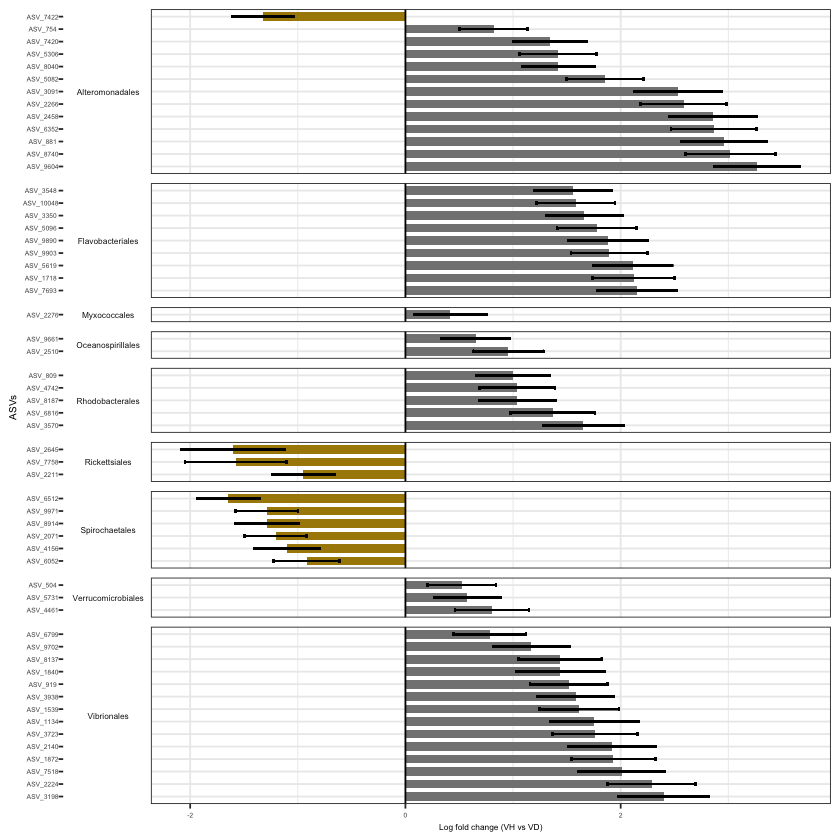

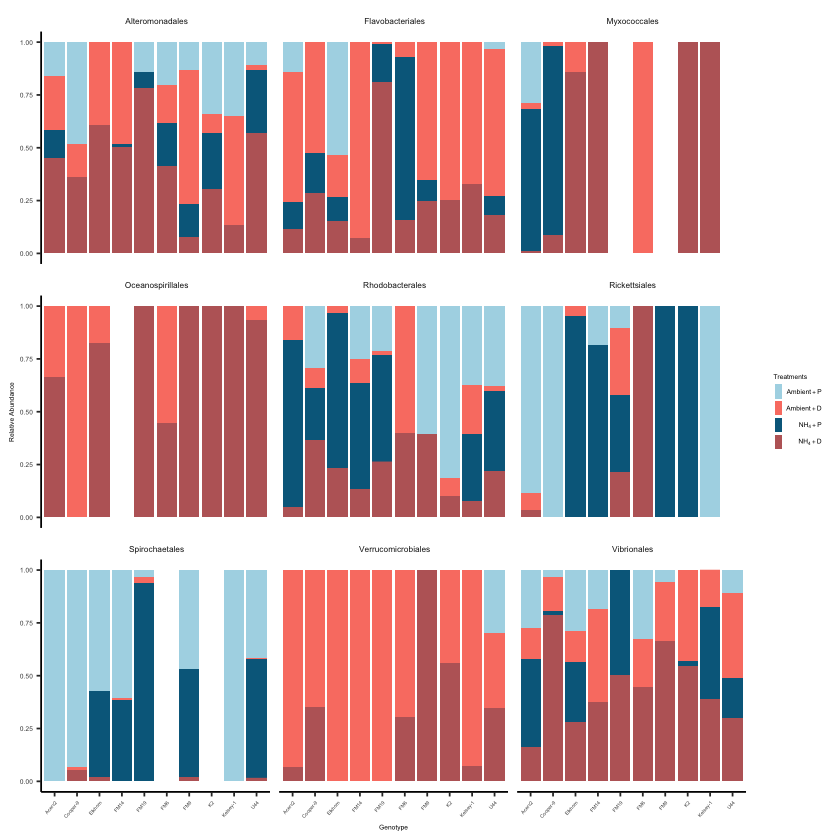

In [66]:
library(dplyr)


lab1 <- c(expression(Ambient+P),
          expression(Ambient+D), 
          expression(NH[4]+P),
          expression(NH[4]+D))


F1 = psr_fill_melt %>%

#as.data.frame %>%
mutate_all(type.convert) %>%
mutate_if(is.factor, as.character) %>%
#arrange(SurvivorshipResistant) %>%
#filter(HealthDL > 1 )  %>%
#filter(HealthDL > 1 | HealthDL <= -1)  %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "") %>%
ggplot(
           aes(x = HealthDL, y = reorder(ASVs, -HealthDL),
               fill =group)) + 
  geom_bar(stat = "identity", width = 0.7, 
           position = position_dodge(width = 0.4)) +
  geom_errorbar(aes(xmin = as.numeric(HealthDL) - as.numeric(HealthDLSD), 
xmax = as.numeric(HealthDL) + as.numeric(HealthDLSD)),
               width = 0.2,
               position = position_dodge(0.05), color = "black") + 
  labs(y = "ASVs", x = "Log fold change (VH vs VD)") + 
  theme_bw() + 
guides(fill = guide_legend(keywidth = 0.3, , keyheight =.90, ncol=1))  +
theme(axis.text.y = element_blank()) +
#facet_wrap(Genotype~., scales = "free_x") +
scale_fill_manual(values=c( 
                        "#AA8805", "#838383")) +

theme(axis.title.x = element_text(size = 5)) +
theme(axis.title.y = element_text(size = 6)) +
#theme(axis.text.y = element_blank()) +
theme(axis.text.x = element_text(size =4)) +
theme(strip.text.y = element_text(size =4)) +
#theme(axis.text.y=element_blank()) +
theme(axis.text.y = element_text(size =4)) +
guides(color = guide_legend(keywidth = 0.2, , keyheight =.40, nrow=1)) +
#theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
theme(legend.text =element_text(size=6)) +
theme(legend.title = element_text(size=6)) +
facet_grid(Order~., space ="free", scales="free", switch="y") +
theme(strip.background = element_blank()) +
theme(strip.text.y.left = element_text(angle =0 )) +
theme(strip.text.y = element_text(size = 5)) +
geom_vline(xintercept = 0,  
                color = "black", size=.5)  +
theme(legend.position = "none")



F1

psr_fill_melt$Combo = factor(psr_fill_melt$Combo, levels = c("Ambient_Placebo",  "Ambient_Pathogen","NH4_Placebo", 
                                                             "NH4_Pathogen"))


F2 = psr_fill_melt %>%
as.data.frame %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "") %>%


#mutate_all(type.convert) %>%
#mutate_if(is.factor, as.character) %>%
arrange(HealthDL) %>%
#filter(HealthDL > 1 | HealthDL <= -1)  %>%
filter(Severity != "NA")  %>%



ggplot(
       aes(x=Genotype, y= Abundance, fill=Combo)) +
geom_bar(stat = "identity",position="fill") +
theme_classic() +

scale_fill_manual("Treatments", values = c( "lightblue", "salmon", "#00688B", "#bc6767"), labels= lab1) + 

theme(strip.background = element_rect(fill="white")) +
guides(fill = guide_legend(keywidth = 0.4, keyheight =.70, ncol=1)) +
#theme(panel.border=element_blank(), axis.line=element_line()) +
#facet_grid(Order~., space ="free", scales="free", switch = "y") +
facet_wrap(Order~.) +
theme(strip.background = element_blank()) +
 labs(fill = "Treatment") +
theme(axis.title.x = element_text(size = 4)) +
theme(legend.text =element_text(size=4)) +
theme(legend.title = element_text(size=4)) +
#theme(legend.position="top") +
theme(axis.title.y = element_text(size=4)) +
theme(axis.text.y = element_text(size=4)) +

theme(axis.text.x = element_text(angle = 50, hjust = 1, size=3)) +
theme(strip.text.x = element_text(size = 5)) +
ylab("Relative Abundance") +
xlab("Genotype") 

F2

Warning message:
“Removed 448 rows containing missing values (position_stack).”
Warning message:
“Removed 242 rows containing missing values (geom_bar).”


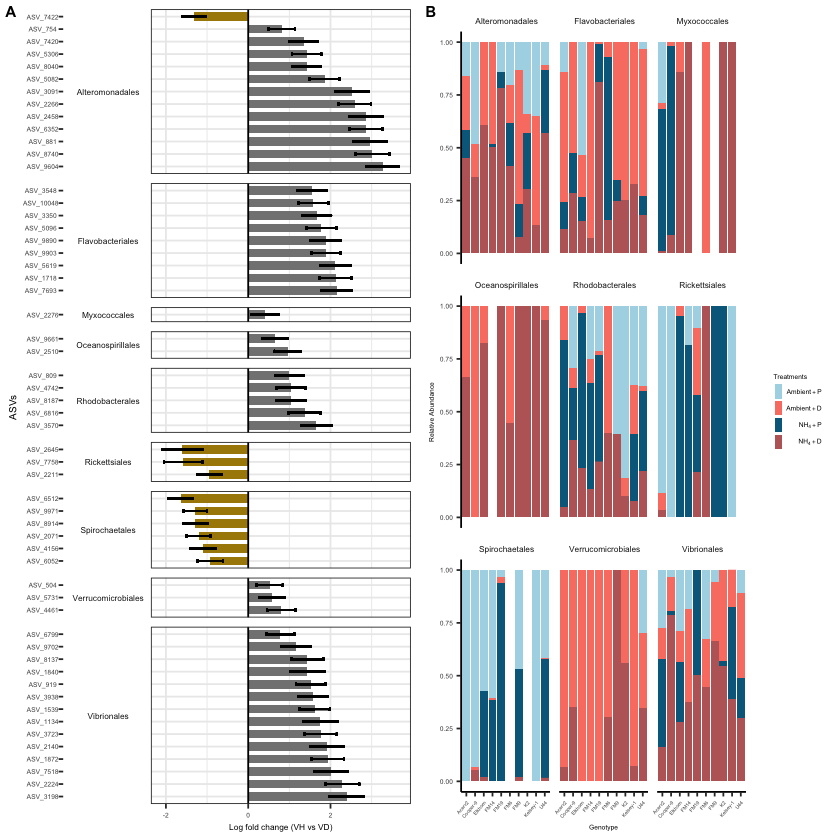

In [23]:
 ggpubr::ggarrange(F1, F2,
                  common.legend = FALSE,
                labels = c("A", "B"), font.label = list(size = 9))
ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/ANCOM_lesion.jpg", 
      width = 7, height = 6, units = "in", dpi=300)

In [14]:
ps= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(as.data.frame(taxa_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(meta), tree_file)
ps
first_hom=c("N88-Hom-H", "N88-Hom-H-R2", "N87-Hom-D", "N87-Hom-D-R2")


ps_homgenate=subset_samples(ps, Type=="Homogenate"& sample_names %in% first_hom)
ps_homgenate

ps_homgenate = filter_taxa(ps_homgenate, function(x) sum(x > 0) > (0.0*length(x)), TRUE)
ps_homgenate 


sum_homogenate   <- ps_homgenate %>%
  #tax_glom(taxrank = "Family") %>%
  #transform_sample_counts(function(x) {x/sum(x)*100} ) %>% # Transform to rel. abundance
  psmelt()

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 467 taxa and 4 samples ]
sample_data() Sample Data:       [ 4 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 467 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 467 tips and 458 internal nodes ]

In [22]:
ps_ancom_APa

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 56 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 56 taxa by 13 taxonomic ranks ]

In [23]:
hom_ASVs = as.data.frame(tax_table(ps_ancom_APa)) %>%
rownames_to_column("taxon") %>%
inner_join(as.data.frame(tax_table(ps_homgenate), "ASVs")) %>%
column_to_rownames("taxon") %>%
as.matrix


ps_home_disase= phyloseq(otu_table(ps_ancom_APa, taxa_are_rows=TRUE), 
               sample_data(meta),
              tax_table(hom_ASVs))
ps_home_disase


Joining, by = c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species", "ASVs")


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 20 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 20 taxa by 13 taxonomic ranks ]

In [92]:
tax_table(ps_home_disase)

,HealthDL,HealthDLSD,group,Sig,Feature.ID,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
5cf3ca8696f1c1d798cd212e989815fd,1.7608001,0.3931298,DL,TRUE,5cf3ca8696f1c1d798cd212e989815fd,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Vibrionales,f__Vibrionaceae,g__Vibrio,NA,ASV_3723
7f3bcdfafa2c3af752914cfe5134586c,1.8542403,0.3592455,DL,TRUE,7f3bcdfafa2c3af752914cfe5134586c,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Pseudoalteromonadaceae,g__Algicola,s__uncultured_bacterium,ASV_5082
cd1c36a7f04147fce84ecdb93d5ef05c,1.4365701,0.3880940,DL,TRUE,cd1c36a7f04147fce84ecdb93d5ef05c,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Vibrionales,f__Vibrionaceae,g__Vibrio,NA,ASV_8137
f242850c598d509ac98aea5999f2779f,3.2668913,0.3988997,DL,TRUE,f242850c598d509ac98aea5999f2779f,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Colwelliaceae,g__Thalassotalea,NA,ASV_9604
41861cce34e32070bc99d36682bf7540,-1.5980216,0.4797544,AH,TRUE,41861cce34e32070bc99d36682bf7540,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rickettsiales,f__Fokiniaceae,g__MD3-55,NA,ASV_2645
f3cbf8aa9b819fca152b898abba14df5,0.6512699,0.3168124,DL,TRUE,f3cbf8aa9b819fca152b898abba14df5,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Oceanospirillales,f__Nitrincolaceae,g__Nitrincolaceae,s__uncultured_gamma,ASV_9661
4ca08cf028bb6992f998bf37f206c01d,2.5297134,0.4059848,DL,TRUE,4ca08cf028bb6992f998bf37f206c01d,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Colwelliaceae,g__Thalassotalea,NA,ASV_3091
38aba94dbec43fa6b556380a38156e8c,2.5855011,0.4001656,DL,TRUE,38aba94dbec43fa6b556380a38156e8c,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Colwelliaceae,g__Thalassotalea,NA,ASV_2266
2de04f6ef9c9089393685ee308a4ec93,1.4396435,0.4091651,DL,TRUE,2de04f6ef9c9089393685ee308a4ec93,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Vibrionales,f__Vibrionaceae,g__Vibrio,NA,ASV_1840
dcb7ebb3749df706e8921afcf88d7f93,3.0188236,0.4170290,DL,TRUE,dcb7ebb3749df706e8921afcf88d7f93,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Colwelliaceae,g__Thalassotalea,NA,ASV_8740


In [25]:
sum_home_disase = ps_home_disase %>%
  #tax_glom(taxrank = "Family") %>%
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()

In [79]:
library(forcats)

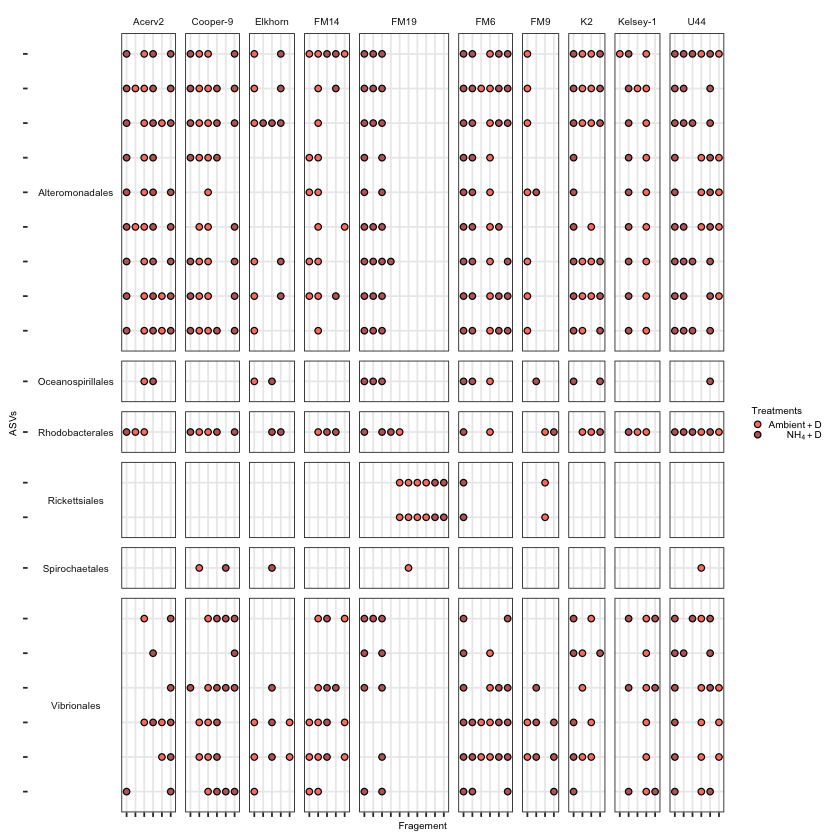

In [91]:

lab1 <- c(
          expression(Ambient+D), 
         
          expression(NH[4]+D))

sum_home_disase  %>%
filter(Abundance !=0) %>%
filter(Combo!="Ambient_Placebo") %>%
filter(Combo!="NH4_Placebo") %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%

ggplot(
           aes(x=sample_names, y = ASVs, fill=Combo)) + 
# geom_bar(stat = "identity",position="fill") +
           #, position = position_(width = 0.3)) +
 

geom_point(pch=21, colour="black" ) +
  theme_bw()  +
scale_fill_manual("Treatments", values = c(  "salmon", "#bc6767"), labels= lab1) + 

#scale_fill_manual("Nutrients", values = c("salmon", "#bc6767")) + 
labs(y = "ASVs", x = "Fragement") + 
theme(strip.background = element_rect(fill="white")) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.y = element_text(size =6)) +
#theme(axis.text.x=element_blank()) +
theme(axis.text.y=element_blank()) +
theme(axis.text.x=element_blank()) +
guides(fill = guide_legend(keywidth = 0.5, keyheight =.35, ncol=1)) +
#theme(panel.border=element_blank(), axis.line=element_line()) +
facet_grid(Order~Genotype, space ="free", scales="free", switch = "y") +
theme(strip.background = element_blank()) +
theme(strip.text.y.left = element_text(angle =0, size=6 )) +
#theme(strip.text.y = element_blank()) +
#theme(strip.text.x = element_blank()) +
theme(legend.text =element_text(size=6)) +
theme(legend.title = element_text(size=6)) +
theme(strip.text.x = element_text(size=6)) 
#aes(x = fct_inorder(Nutrients))


ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/Common_ANCOM_HOM.jpg", 
      width = 7, height = 6, units = "in", dpi=300)

Warning message:
“Removed 540 rows containing missing values (position_stack).”


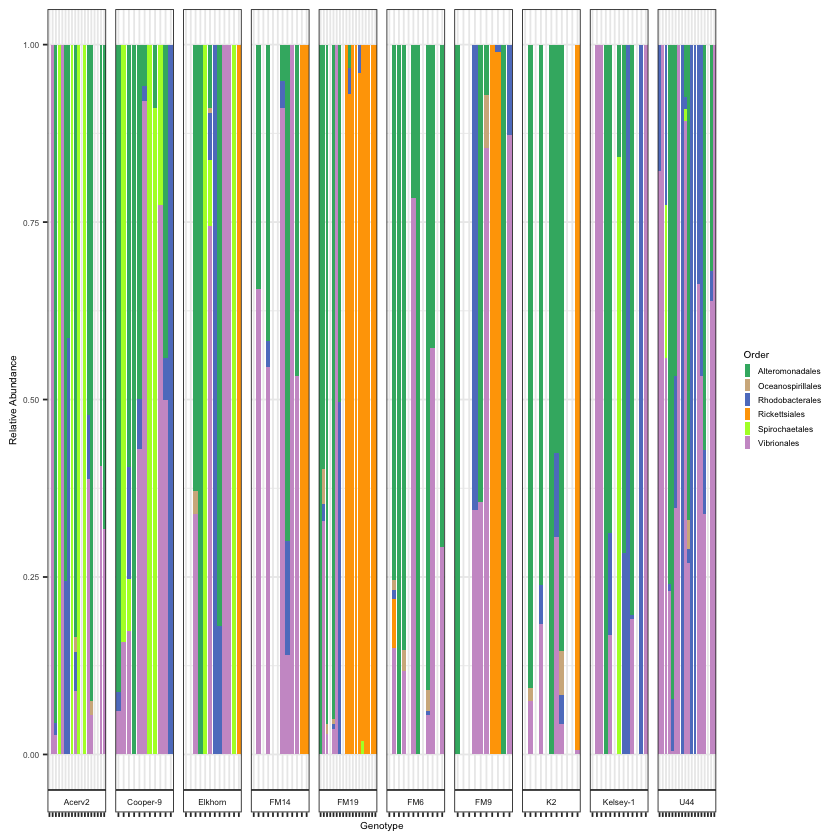

In [27]:
sum_home_disase  %>%
#filter(Abundance >0.009) %>%
mutate_if(
                is.character, 
                stringr::str_replace_all, 
                pattern = "o__",
                replacement = "")  %>%
ggplot(
       aes(x=sample_names, y= Abundance, fill=Order)) + 
theme_bw() +
geom_bar(stat = "identity",position="fill") +

#geom_boxplot() +
#scale_y_continuous(trans = "log10") +
#geom_point(position = position_jitterdodge(), alpha=0.5, size=1) +
facet_grid(.~Genotype, scales="free_x",  switch="both") +
scale_fill_manual(values=c("#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F",
                          "lightblue", "#CD9BCD","gray80","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724"
                           ,"#8fa746","#404b1f","#8FBC8F",
                           "#3CB371","tan","#5F7FC7", "orange","#ADFF2F", 
                           "#CD9BCD", "gray80", "darkolivegreen4", "#673770","#D14285", 
                           "#8569D5", "#5E738F","#AD6F3B",
                          "lightblue", "salmon","Navy", "#CBD588",
                           "lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F", 
                            "khaki1","#41636f","#00AEEF","#8bbfd2","brown","#AD6F3B","tan",
                           "#90EE90","#8fa746","lightblue4", "ivory4", "darkorchid", "palevioletred1",
                           "#DA5724","#CD9BCD","#8fa746","#404b1f","#8FBC8F"
                          )) +
#geom_point(aes(size= Abundance), alpha=0.4) +
theme_bw() +
theme(legend.title = element_text(size=10)) +
#labs(fill='Taxon')  +
ylab("Relative Abundance") +
xlab("Genotype") +
guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
theme(strip.background = element_rect(fill="white")) +
theme(axis.text.x = element_blank()) +
theme(strip.text.x = element_text(size = 5)) +
theme(legend.text =element_text(size=5)) +
theme(legend.title = element_text(size=6)) +
theme(axis.title.x = element_text(size = 6)) +
theme(axis.title.y = element_text(size = 6)) +
theme(axis.text.y = element_text(size =5)) 